# IMDB Review Text Classification

### Problem Description
In this project I would like to be able to take a movie review from IMDB and classify it as a positive review or a negative review. To do this I will be using natrual language processing on a dataset that I found on Kaggle (https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

The problem that I would like to solve with this is being able to understand the views of commentors on movies based on what they write on them.

In [65]:
import pandas as pd
import numpy as np

from __future__ import absolute_import, division, print_function, unicode_literals
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
sns.set(rc={'figure.figsize' : (12, 6)})
sns.set_style("darkgrid", {'axes.grid' : True})
import skimage
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dropout, BatchNormalization, Dense
import re
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

# Load in the Data

In [4]:
reviews = pd.read_csv('IMDB Dataset.csv')
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Description of Dataset

### Description
This dataset contains 50000 reviews about movies from IMDB. It is equally split between positive and negative reviews.

### Data Columns:
review - The text of the review
sentiment - this is the target variable of positive or negative.

# EDA

In [10]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


[Text(0.5, 1.0, 'Positive and Negagive Split')]

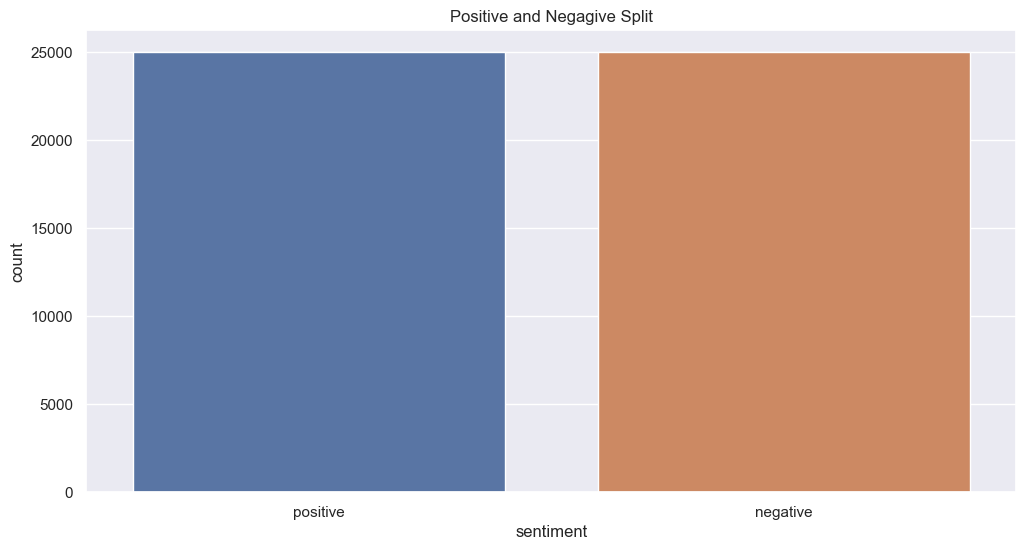

In [13]:
sns.countplot(x=reviews.sentiment).set(title = 'Positive and Negagive Split')

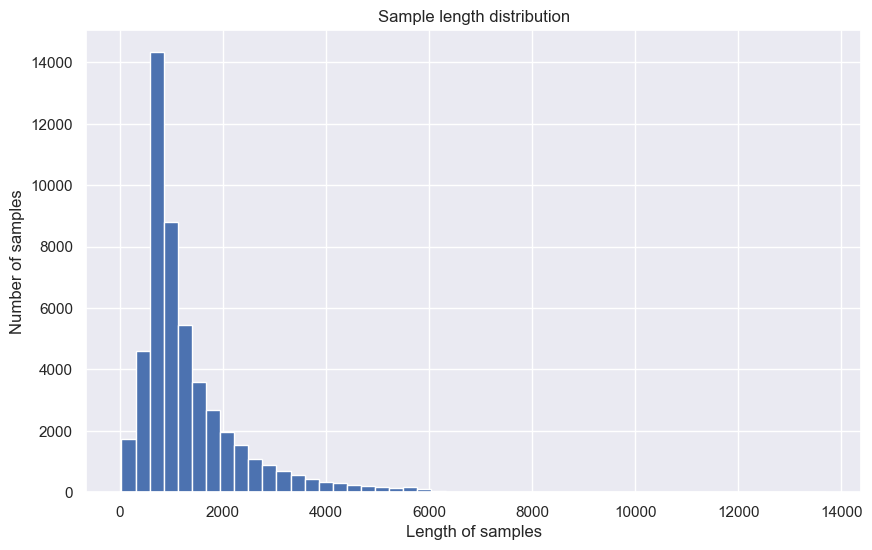

In [17]:
plt.figure(figsize=(10, 6))
plt.hist([len(sample) for sample in list(reviews['review'])], 50)
plt.xlabel('Length of samples')
plt.ylabel('Number of samples')
plt.title('Sample length distribution')
plt.show()

# Data Preprocessing

In [16]:
# encode sentiment column in dataset 1 = positive and 0 = negative
label_encoder = preprocessing.LabelEncoder()
reviews['sentiment'] = label_encoder.fit_transform(reviews['sentiment'])
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [55]:
stop = list(stopwords.words("english"))

punctuation = list(string.punctuation)

lemma = WordNetLemmatizer()

sw_pun = stop + punctuation

In [57]:
text_clean = []
for index, row in reviews.iterrows():
    txt = row['review']
    txt = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", txt)  
    txt = re.sub('[^\w]',' ',txt)          
    txt = re.sub('[\d]','',txt) 
    txt = txt.lower()
    words = txt.split() 
    sentence = ""
    for word in words:     
        if word not in (sw_pun):                
            word = lemma.lemmatize(word,pos = 'v')    
            if len(word) > 3: 
                sentence = sentence + word + ' '
                
    text_clean.append(sentence)
    
reviews['text_clean'] = text_clean

In [58]:
reviews

,review,sentiment,text_clean
0,One of the other reviewers has mentioned that ...,1,reviewers mention watch episode hook right exa...
1,A wonderful little production. <br /><br />The...,1,wonderful little production film technique una...
2,I thought this was a wonderful way to spend ti...,1,think wonderful spend time summer weekend cond...
3,Basically there's a family where a little boy ...,0,basically family little jake think zombie clos...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,petter mattei love time money visually stun fi...
...,...,...,...
49995,I thought this movie did a down right good job...,1,think movie right good creative original first...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0,plot dialogue idiotic direct annoy porn groove...
49997,I am a Catholic taught in parochial elementary...,0,catholic teach parochial elementary school nun...
49998,I'm going to have to disagree with the previou...,0,disagree previous comment side maltin second r...


In [59]:
# Splitting the data into 2/3 as train and 1/3 as test
X_train, X_test, y_train, y_test = train_test_split(reviews['text_clean'], reviews['sentiment'], test_size=0.33, random_state=42)

In [60]:
X_train

23990    randolph scott head albuquerque take uncle how...
8729     like movie cause good approach buddhism exampl...
3451     well expect anything deep meaningful fight sce...
2628     really deserve even negative watch show show j...
38352    dwight frye steal show foolish young seem ment...
                               ...                        
11284    shadow magic recapture amazement first movie a...
44732    find movie quite enjoyable fairly entertain go...
38158    avoid terrible movie excite pointless murder w...
860      production quite surprise absolutely love obsc...
15795    decent movie although little bite short time p...
Name: text_clean, Length: 33500, dtype: object

In [61]:
vocab_size = 10000
embedding_dim = 16
max_length = 50
trunc_type='post'
oov_tok = "<OOV>"

# Tokenization
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)

# Padding
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

# Build Models

### GRU

In [81]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history_gru = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 16)          160000    
                                                                 
 dropout_4 (Dropout)         (None, None, 16)          0         
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)               31488     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 6)                 774       
                                                                 
 dense_15 (Dense)            (None, 1)                 7         
                                                                 
Total params: 192269 (751.05 KB)
Trainable params: 192269 (751.05 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

### LSTM

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 10
history_lstm = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test))

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 64)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 677249 (2.58 MB)
Trainable params: 677249 (2.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1047/1047 [==============================] - 41s 36ms/step - loss: 0.4272 - accuracy: 0.7990 - val_loss: 0.3532 - val_accuracy: 0.8427
Epo

# Model Visualizations

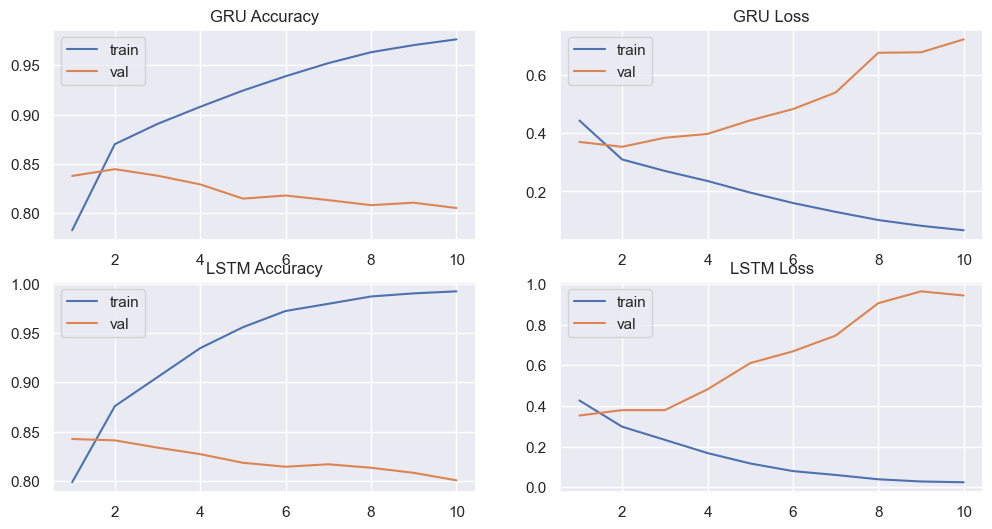

In [82]:
figure, axis = plt.subplots(2, 2)

epochs = range(1,11)
axis[0, 0].plot(epochs, history_gru.history['accuracy'], label = 'train')
axis[0, 0].plot(epochs, history_gru.history['val_accuracy'], label = 'val')
axis[0, 0].legend()
axis[0, 0].set_title('GRU Accuracy')

epochs = range(1,11)
axis[0, 1].plot(epochs, history_gru.history['loss'], label = 'train')
axis[0, 1].plot(epochs, history_gru.history['val_loss'], label = 'val')
axis[0, 1].legend()
axis[0, 1].set_title('GRU Loss')

epochs = range(1,11)
axis[1, 0].plot(epochs, history_lstm.history['accuracy'], label = 'train')
axis[1, 0].plot(epochs, history_lstm.history['val_accuracy'], label = 'val')
axis[1, 0].legend()
axis[1, 0].set_title('LSTM Accuracy')

epochs = range(1,11)
axis[1, 1].plot(epochs, history_lstm.history['loss'], label = 'train')
axis[1, 1].plot(epochs, history_lstm.history['val_loss'], label = 'val')
axis[1, 1].legend()
axis[1, 1].set_title('LSTM Loss')
plt.show()

# Discussion/Conclusion

The problem that I attempted to solve with this project was to classify IMDB movie reviews as positive or negative based on the text of the review. I utilized both an LSTM model as well as a GRU model. Both of these model architectures were discussed in class and showed potential to solve this problem. On the training data sets the GRU model achieved an accuracy of .9761 and the LSTM model acheived an accuracy of .9921. These are both very good accuracies on the training set, but as expected they performed poorer on the validation set. The GRU model acheived an accuracy of .8063 whereas the LSTM acheived an accuracy of .8009. This is an indication of some overfitting going on in these models, especially since on the LSTM, the accuracy decreased over the epochs. Initially I had more overfitting, but I solved this by adding some dropout layers. Sadly it did not solve all of the overfitting issues. Overall the best performing model was the GRU model, with a higher accuracy of ___ and seemed to overfit less.

In the future, I would like to solve the overfitting by potentially decreasing the vocabulary size, and maybe even trying a different model architecture, but I ran out of time for this notebook.

Even though these models are not perfect, I believe that an accuracy of ___ is still pretty good for understanding sentiment through text. A model such as this could be applied to any number of reviews, not just movies, or potentially chats, identifying customer satisfaction. If further improvements were made, then this model could be viably used in production.